In [1]:
print("hi")

hi


In [1]:
!pip install onnxruntime mediapipe

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# فك الضغط

zip_path = "/content/drive/MyDrive/Sila Dataset/Mydata.zip"

In [18]:

# نفك الضغط داخل مجلد ثابت
!unzip -q "$zip_path" -d /content/dataset

replace /content/dataset/__MACOSX/Mydata/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [19]:
# نتأكد إن المجلدات موجودة
!ls "/content/dataset/Mydata"

test  train  val


# ***Install and import***

In [6]:
# بعد Restart
import os, json, time, math, random, shutil
from pathlib import Path
from glob import glob

import numpy as np
import onnxruntime as ort
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_recall_fscore_support)
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

print("✅ Ready!")
print(f"numpy: {np.__version__}")
print(f"opencv: {cv2.__version__}")
print(f"mediapipe: {mp.__version__}")
print(f"onnxruntime: {ort.__version__}")
print(f"torch: {torch.__version__}")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


✅ Ready!
numpy: 1.26.4
opencv: 4.11.0
mediapipe: 0.10.21
onnxruntime: 1.23.2
torch: 2.8.0+cu126


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")    # لو ماك (Apple Silicon)
elif torch.cuda.is_available():
    device = torch.device("cuda")   # لو ويندوز/لينكس و فيه  GPU
else:
    device = torch.device("cpu")    # fallback
print("Device:", device)

Device: cuda


# ***Controls and Tracks***

In [8]:
# استخدم ناتج التقسيم/التوازن اللي سويته قبل شوي
SPLIT_SRC = Path("/content/dataset/Mydata")

IMG_SIZE   = 64
BATCH_SIZE = 64
EPOCHS     = 15
LR         = 1e-3
SEED       = 42

torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# نحدد الكلاسات من مجلد train تلقائيًا
classes = sorted([d.name for d in (SPLIT_SRC/"train").iterdir() if d.is_dir()])
num_classes = len(classes)      #يحسب عددها ويعمل قاموسين
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
print("Classes:", len(classes), classes[:10], "...")


Classes: 32 ['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain'] ...


# ***Simple data-loader for 64x64 grayscale images***

In [9]:
from PIL import Image
import cv2, mediapipe as mp, numpy as np
from torchvision import transforms
from torch.utils.data import Dataset

# نهيّئ MediaPipe مرّة وحدة
_mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

def crop_hand_pil(img_pil: Image.Image) -> Image.Image:
    """يقصّ اليد إن وُجدت وإلا يرجّع الصورة الأصلية."""
    bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]
    res = _mp_hands.process(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    if res.multi_hand_landmarks:
        xs, ys = [], []
        for lm in res.multi_hand_landmarks[0].landmark:
            xs.append(int(lm.x * w)); ys.append(int(lm.y * h))
        x1, x2 = max(0, min(xs)-20), min(w, max(xs)+20)
        y1, y2 = max(0, min(ys)-20), min(h, max(ys)+20)
        crop = bgr[y1:y2, x1:x2]
        if crop.size > 0:
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            return Image.fromarray(rgb)
    return img_pil

class GrayFolderDataset(Dataset):
    def __init__(self, root: Path, class_to_idx: dict, aug=False):
        self.items = []
        self.class_to_idx = class_to_idx

        # نجمع المسارات والليبل
        for c in sorted(root.iterdir(), key=lambda p: p.name):
            if not c.is_dir(): continue
            label = class_to_idx[c.name]
            for p in c.iterdir():
                if p.suffix.lower() in {".png", ".jpg", ".jpeg", ".bmp"}:
                    self.items.append((p, label))

        # تحويلات بعد القصّ
        base = [
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
        if aug:
            self.tf = transforms.Compose([transforms.RandomAffine(5, translate=(0.03,0.03))] + base)
        else:
            self.tf = transforms.Compose(base)

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")
        img = crop_hand_pil(img)              # قصّ اليد
        img = self.tf(img.convert("L"))       # رمادي + ري سايز + نورمالايز
        return img, label
from torch.utils.data import DataLoader

train_ds = GrayFolderDataset(SPLIT_SRC/"train", class_to_idx, aug=True)
val_ds   = GrayFolderDataset(SPLIT_SRC/"val",   class_to_idx, aug=False)
test_ds  = GrayFolderDataset(SPLIT_SRC/"test",  class_to_idx, aug=False)

# مهم: num_workers=0 مع MediaPipe
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# فحص سريع
xb, yb = next(iter(train_dl))
print("Batch:", xb.shape, yb.shape)  # متوقع: [B, 1, 64, 64], [B]

Batch: torch.Size([64, 1, 64, 64]) torch.Size([64])


In [10]:
!ls "/content/drive/MyDrive"
!ls "/content/drive/MyDrive/Sila Dataset"
!ls "/content/drive/MyDrive/Sila Dataset/models"

'Amirah Aldajani.pdf'
"Amirah Aldajani's CV"
'Colab Notebooks'
'E-commerce Management system '
 Ghiras_dataset
'KA Programs Introductory Session Registration (Responses).gsheet'
 NamtLogo.png
 Sila
'Sila Dataset'
 test0
 test.gsheet
 ُTest.gsheet
'Untitled form.gform'
'Untitled project.gscript'
'أميرة الدعجاني'
 تقديمي.gsheet
 166125298803261.jpg   Mydata.zip
'AL (39).png'	      'SAAD (746).png'
'Aleff (60).png'      'Screenshot 2025-11-09 at 3.57.12 PM.png'
 dha.jpg	      'Screenshot 2025-11-09 at 4.02.14 PM.png'
'FA (6).png'	      'Screenshot 2025-11-09 at 4.18.39 PM.png'
'GHAIN (77).png'      'Screenshot 2025-11-09 at 4.21.30 PM.png'
'JEEM (213).png'      'THAL (823).png'
'KAAF (259).png'       Zay.jpg
'MEEM (206).png'
ls: cannot access '/content/drive/MyDrive/Sila Dataset/models': No such file or directory


# ***Light weight, accurate model for 64x64 grayscale photos***

In [11]:
# ***MobileNetV2 version for Mubsir (optimized for grayscale 64x64)***
from torchvision import models
import torch.nn as nn

# إنشاء MobileNetV2 بدون أوزان مسبقة (نبدأ من الصفر)
model = models.mobilenet_v2(weights=None)

# تعديل أول طبقة لتقبل قناة واحدة فقط (لأن صورك رمادية)
# الأصلية تتوقع 3 قنوات (RGB)
model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=32,
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

# تعديل الطبقة النهائية لتتناسب مع عدد الكلاسات
model.classifier[1] = nn.Linear(
    in_features=1280,
    out_features=num_classes,
    bias=True
)

# نقل النموذج إلى الجهاز المستخدم (CPU / GPU / MPS)
model = model.to(device)

# إعدادات التدريب نفسها
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()

# فحص حجم النموذج
params_m = sum(p.numel() for p in model.parameters()) / 1e6
print(f"✅ MobileNetV2 model ready with {num_classes} classes.")
print(f"Model params (M): {params_m:.3f}")

✅ MobileNetV2 model ready with 32 classes.
Model params (M): 2.264


# ***Training with optimal weight retention and simple Early Stop***

In [12]:
from collections import deque
from pathlib import Path
import torch

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0

    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        loss_sum += loss.item() * yb.size(0)

    return loss_sum / total, correct / total


best_val_acc = 0.0
patience, bad = 4, 0
best_path = Path("./models/best_mubsir_mnetv2.pt")
best_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(val_dl, train=False)
    scheduler.step()

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.4f}"
    )

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad = 0
        torch.save(
            {
                "model": model.state_dict(),
                "classes": classes,
                "img_size": IMG_SIZE,
            },
            best_path
        )
        print("  saved:", best_path)
    else:
        bad += 1
        if bad >= patience:
            print("Early stop")
            break

print("Best val acc:", best_val_acc)

Epoch 01/15 | train loss 1.4959 acc 0.5399 | val loss 0.5357 acc 0.8364
  saved: models/best_mubsir_mnetv2.pt
Epoch 02/15 | train loss 0.4154 acc 0.8672 | val loss 0.2502 acc 0.9221
  saved: models/best_mubsir_mnetv2.pt
Epoch 03/15 | train loss 0.2660 acc 0.9188 | val loss 0.1775 acc 0.9453
  saved: models/best_mubsir_mnetv2.pt
Epoch 04/15 | train loss 0.2131 acc 0.9351 | val loss 0.1553 acc 0.9535
  saved: models/best_mubsir_mnetv2.pt
Epoch 05/15 | train loss 0.1629 acc 0.9501 | val loss 0.1167 acc 0.9659
  saved: models/best_mubsir_mnetv2.pt
Epoch 06/15 | train loss 0.1327 acc 0.9594 | val loss 0.0980 acc 0.9725
  saved: models/best_mubsir_mnetv2.pt
Epoch 07/15 | train loss 0.1016 acc 0.9678 | val loss 0.0835 acc 0.9748
  saved: models/best_mubsir_mnetv2.pt
Epoch 08/15 | train loss 0.0856 acc 0.9728 | val loss 0.0938 acc 0.9740
Epoch 09/15 | train loss 0.0629 acc 0.9799 | val loss 0.0789 acc 0.9760
  saved: models/best_mubsir_mnetv2.pt
Epoch 10/15 | train loss 0.0481 acc 0.9843 | val

# ***Test evaluation and reports***

=== Final (TEST) Metrics ===
Accuracy : 0.9831
Precision: 0.9830
Recall   : 0.9831
F1-Score : 0.9830

[Optional] Weighted Averages
Precision_w: 0.9832 | Recall_w: 0.9831 | F1_w: 0.9831

Per-class report:
              precision    recall  f1-score   support

         ain     1.0000    0.9948    0.9974       193
          al     1.0000    0.9925    0.9963       134
       aleff     0.9732    0.9797    0.9764       148
          bb     0.9811    0.9689    0.9750       161
         dal     0.9859    0.9655    0.9756       145
         dha     0.9610    0.9548    0.9579       155
        dhad     1.0000    0.9732    0.9864       149
          fa     0.9829    0.9773    0.9801       176
        gaaf     0.9730    0.9536    0.9632       151
       ghain     0.9944    0.9944    0.9944       179
          ha     0.9514    0.9648    0.9580       142
         haa     0.9565    0.9851    0.9706       134
        jeem     0.9784    1.0000    0.9891       136
        kaaf     1.0000    0.9811    0.

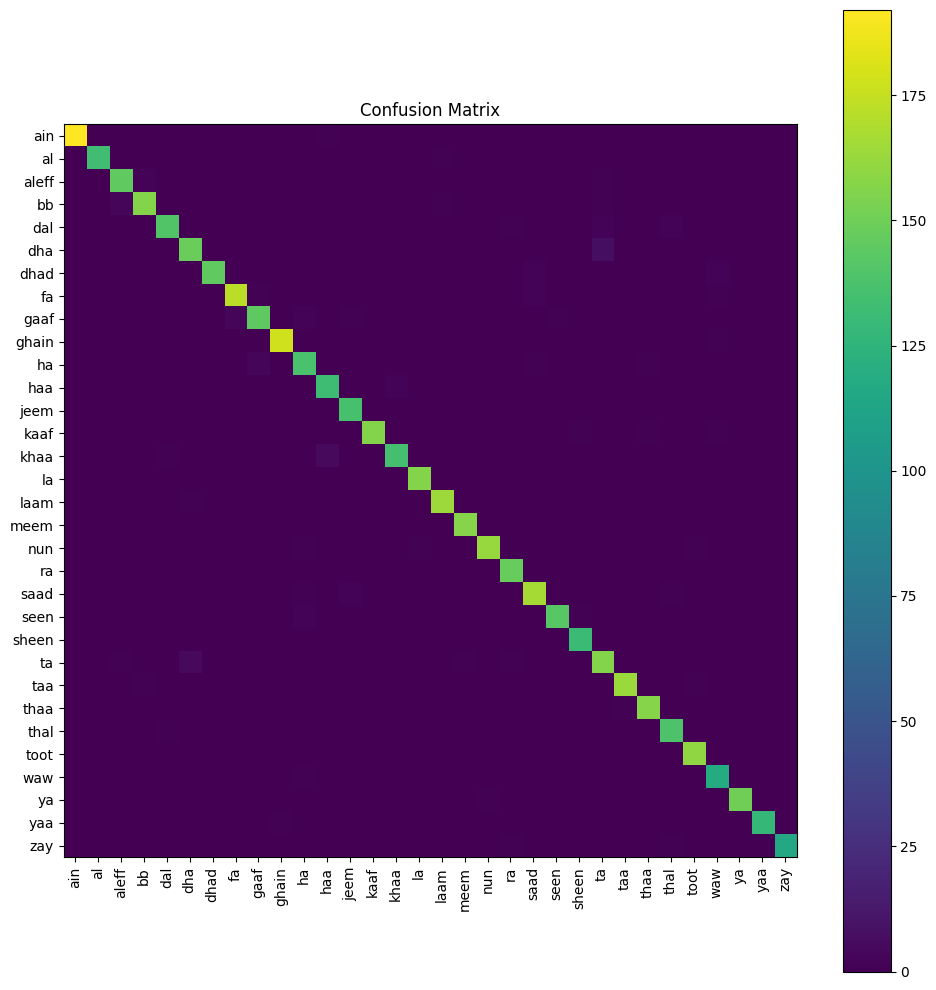

In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import torch

ckpt = torch.load(best_path, map_location=device)
classes = ckpt["classes"]
num_classes = len(classes)
model.load_state_dict(ckpt["model"])
model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_targets.extend(yb.numpy().tolist())

acc = accuracy_score(all_targets, all_preds)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="macro", zero_division=0
)

print("=== Final (TEST) Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall   : {rec_macro:.4f}")
print(f"F1-Score : {f1_macro:.4f}")

prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="weighted", zero_division=0
)
print("\n[Optional] Weighted Averages")
print(f"Precision_w: {prec_w:.4f} | Recall_w: {rec_w:.4f} | F1_w: {f1_w:.4f}")

print("\nPer-class report:")
print(classification_report(all_targets, all_preds, target_names=classes, digits=4, zero_division=0))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(num_classes), classes, rotation=90)
plt.yticks(range(num_classes), classes)
plt.tight_layout()
plt.show()

# ***Inference & Testing***
### هنا يطوال الاعمار ندرج صورة للمودل ونشوف نسبة الثقه انه يتعرف او لا او انه مودل يهبد لنا

Prediction: sheen | Confidence: 99.98%


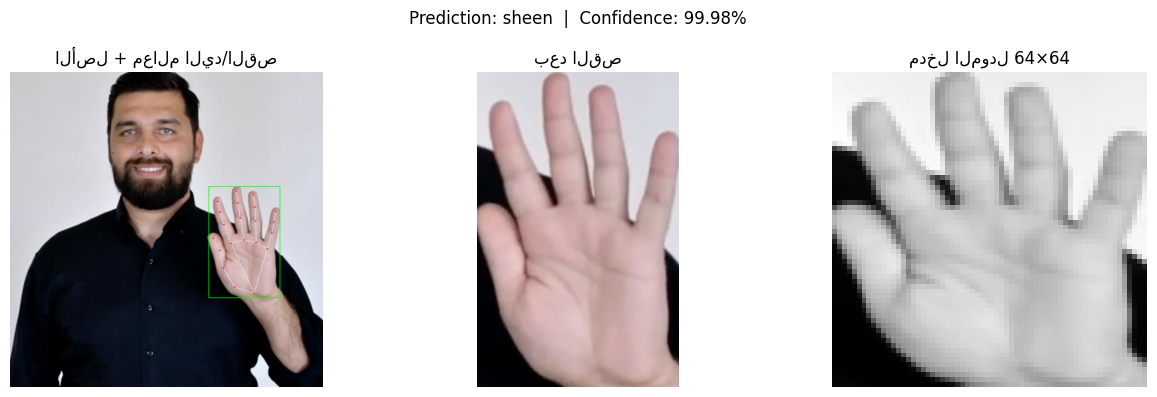

Debug Prediction: sheen | Confidence: 99.98%
Crop box: (880, 507, 1195, 1000)


In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import mediapipe as mp
from pathlib import Path
from torchvision import transforms
import torch

def crop_hand_pil(img_pil: Image.Image, pad=20) -> Image.Image:
    bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]
    with mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        res = hands.process(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    if res.multi_hand_landmarks:
        xs, ys = [], []
        for lm in res.multi_hand_landmarks[0].landmark:
            xs.append(int(lm.x * w)); ys.append(int(lm.y * h))
        x1, x2 = max(0, min(xs)-pad), min(w, max(xs)+pad)
        y1, y2 = max(0, min(ys)-pad), min(h, max(ys)+pad)
        crop = bgr[y1:y2, x1:x2]
        if crop.size > 0:
            rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            return Image.fromarray(rgb)
    return img_pil

def predict_image(path: Path):
    tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
    img_rgb = Image.open(path).convert("RGB")
    img_rgb = crop_hand_pil(img_rgb)
    x = tf(img_rgb.convert("L")).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred_idx = logits.argmax(1).item()
        prob = torch.softmax(logits, dim=1)[0, pred_idx].item()
    return idx_to_class[pred_idx], prob

mp_draw = mp.solutions.drawing_utils

def crop_hand_debug(img_pil: Image.Image, pad=20):
    bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]
    orig_draw = bgr.copy()
    crop_pil, box = img_pil, None
    with mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        res = hands.process(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    if res.multi_hand_landmarks:
        mp_draw.draw_landmarks(
            image=orig_draw,
            landmark_list=res.multi_hand_landmarks[0],
            connections=mp.solutions.hands.HAND_CONNECTIONS
        )
        xs, ys = [], []
        for lm in res.multi_hand_landmarks[0].landmark:
            xs.append(int(lm.x * w)); ys.append(int(lm.y * h))
        x1, x2 = max(0, min(xs)-pad), min(w, max(xs)+pad)
        y1, y2 = max(0, min(ys)-pad), min(h, max(ys)+pad)
        cv2.rectangle(orig_draw, (x1,y1), (x2,y2), (0,255,0), 2)
        crop = bgr[y1:y2, x1:x2]
        if crop.size > 0:
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            box = (x1, y1, x2, y2)
    orig_draw_rgb = cv2.cvtColor(orig_draw, cv2.COLOR_BGR2RGB)
    return crop_pil, box, Image.fromarray(orig_draw_rgb)

def predict_image_debug(path: Path, show=True):
    img_rgb = Image.open(path).convert("RGB")
    crop_pil, box, orig_with_draw = crop_hand_debug(img_rgb)

    tf_infer = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
    x = tf_infer(crop_pil.convert("L")).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(1).item())
        prob = float(torch.softmax(logits, dim=1)[0, pred_idx].item())
    pred_label = idx_to_class[pred_idx]

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(13,4))
        axs[0].imshow(orig_with_draw); axs[0].set_title("الأصل + معالم اليد/القص")
        axs[1].imshow(crop_pil);       axs[1].set_title("بعد القص")
        axs[2].imshow(x[0,0].cpu(), cmap="gray"); axs[2].set_title("مدخل المودل 64×64")
        for a in axs: a.axis("off")
        plt.suptitle(f"Prediction: {pred_label}  |  Confidence: {prob*100:.2f}%")
        plt.tight_layout(); plt.show()

    return pred_label, prob, box

sample_path = Path("/content/drive/MyDrive/Sila Dataset/Screenshot 2025-11-09 at 4.21.30 PM.png")
pred_label, confidence = predict_image(sample_path)
print("Prediction:", pred_label, "| Confidence:", f"{confidence*100:.2f}%")
pred_label, confidence, box = predict_image_debug(sample_path)
print("Debug Prediction:", pred_label, "| Confidence:", f"{confidence*100:.2f}%")
print("Crop box:", box)

In [24]:
# ============================================
# Export model to ONNX (Stable / MobileNetV2)
# ============================================

!pip -q install onnx onnxruntime

import json, torch, onnx, onnxruntime as ort
from torchvision import models
import torch.nn as nn

# 1) تحميل أفضل وزن (من التدريب)
ckpt = torch.load(best_path, map_location="cpu")
classes = ckpt["classes"]
img_size = ckpt.get("img_size", 64)

# 2) إعادة بناء نموذج MobileNetV2 بنفس الإعدادات
export_model = models.mobilenet_v2(weights=None)
export_model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=32,
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)
export_model.classifier[1] = nn.Linear(1280, len(classes))
export_model.load_state_dict(ckpt["model"])
export_model.eval()

# 3) دخل تجريبي بنفس شكل الإدخال الذي درّبت عليه
dummy = torch.randn(1, 1, img_size, img_size)

# 4) مسار حفظ ONNX
onnx_path = "/content/Mubser_model.onnx"

# 5) التصدير إلى ONNX (opset 18)
torch.onnx.export(
    export_model,
    dummy,
    onnx_path,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=18
)

print("✅ Exported:", onnx_path)

# 6) فحص سلامة ملف ONNX
m = onnx.load(onnx_path)
onnx.checker.check_model(m)
print("✅ ONNX check passed")

# 7) اختبار تشغيل سريع باستخدام ONNX Runtime
sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
y = sess.run(None, {"input": dummy.numpy()})[0]
print("✅ ORT inference OK | output shape:", y.shape)

# 8) حفظ الميتاداتا (الفئات + حجم الإدخال)
meta = {"classes": classes, "img_size": img_size}
meta_path = "/content/Mubser_model.meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("✅ Saved meta:", meta_path)

# 9) تحميل الملفات إلى جهازك
from google.colab import files
files.download(onnx_path)
files.download(meta_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 111.9 MB/s eta 0:00:00


/tmp/ipython-input-3236610941.py:37: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Exported: /content/Mubser_model.onnx
✅ ONNX check passed
✅ ORT inference OK | output shape: (1, 32)
✅ Saved meta: /content/Mubser_model.meta.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>